# Exploration of cluster 511, layer 21, activation threshold 1.5, 100 batch graph gen, 5000 cap PCA

In [64]:
%load_ext autoreload
%autoreload 2
import logging
import os
import re
from os.path import join as pj

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import torch
from sae_lens import SAE, ActivationsStore
from scipy import sparse
from transformer_lens import HookedTransformer

from sae_cooccurrence.normalised_cooc_functions import (
    create_results_dir,
    get_sae_release,
    neat_sae_id,
)
from sae_cooccurrence.pca import (
    generate_data,
    generate_subgraph_plot_data_sparse,
    plot_subgraph_static_from_nx,
    plot_token_pca_and_save,
)
from sae_cooccurrence.streamlit import load_streamlit_config, load_subgraph_data
from sae_cooccurrence.utils.saving_loading import load_npz_files, set_device
from sae_cooccurrence.utils.set_paths import get_git_root

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setup

In [33]:
git_root = get_git_root()
torch.set_grad_enabled(False)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [34]:
config = load_streamlit_config(
    pj(git_root, "src", "config_pca_streamlit_maxexamples.toml")
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
fs_splitting_cluster = 511
save_figs = True
subgraph_id = fs_splitting_cluster
layer = 21
activation_threshold = 1.5
activation_threshold_safe = str(activation_threshold).replace(".", "_")
batch_size = 100
pca_cap = 5000
model_name = "gemma-2-2b"
sae_release_short = "gemma-scope-2b-pt-res-canonical"
sae_id = "layer_21/width_16k/canonical"
sae_id_neat = neat_sae_id(sae_id)
n_batches_reconstruction = 100
graph_size = 5
n_batches_generation = 100

In [36]:
results_dir = create_results_dir(
    model_name, sae_release_short, sae_id_neat, n_batches=n_batches_generation
)
results_path = pj(git_root, results_dir)
activation_threshold_safe = str(activation_threshold).replace(".", "_")

In [37]:
file_path = pj(
    get_git_root(),
    results_dir,
    f"layer_{layer}_width_16k_canonical_pca_for_streamlit",
    f"{pca_cap}cap_graph_analysis_results_size_{graph_size}_nbatch_{n_batches_reconstruction}.h5",
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
node_df = pd.read_csv(
    pj(results_path, f"dataframes/node_info_df_{activation_threshold_safe}.csv")
)
logging.info(
    f"Loaded node_df from {pj(results_path, f'dataframes/node_info_df_{activation_threshold_safe}.csv')}"
)

overall_feature_activations = load_npz_files(
    results_path, "feature_acts_cooc_activations"
).get(activation_threshold)

# with open(pj(results_path, f"subgraph_objects/activation_{activation_threshold_safe}/subgraph_{subgraph_id}.pkl"), 'rb') as f:
#     subgraph = pickle.load(f)


# Filter for the specific subgraph
fs_splitting_nodes = node_df.query("subgraph_id == @subgraph_id")["node_id"].tolist()

Loading npz files:   0%|          | 0/1 [00:00<?, ?it/s]

In [39]:
pca_prefix = "pca"
figures_path = pj(git_root, f"figures/{model_name}/{sae_release_short}/{sae_id_neat}")
pca_dir = f"{pca_prefix}_{activation_threshold_safe}_subgraph_{subgraph_id}"
pca_path = pj(figures_path, pca_dir)
if not os.path.exists(pca_path):
    os.makedirs(pca_path)

In [40]:
results, pca_df = load_subgraph_data(
    file_path, subgraph_id, config["processing"]["load_options"]
)

In [41]:
device = set_device()
model = HookedTransformer.from_pretrained(model_name, device=device)
sae_release = get_sae_release(model_name, sae_release_short)
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release=sae_release, sae_id=sae_id, device=device
)
sae.fold_W_dec_norm()
activation_store = ActivationsStore.from_sae(
    model=model,
    sae=sae,
    streaming=True,
    store_batch_size_prompts=8,
    train_batch_size_tokens=4096,
    n_batches_in_buffer=4,
    device=device,
)

Using MPS


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-2b into HookedTransformer


Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/matthew/Library/Caches/pypoetry/virtualenvs/sae-cooccurence-DZTJ6ajw-py3.11/lib/python3.11/site-packages/sae_lens/training/activations_store.py:245: UserWarning:

Dataset is not tokenized. Pre-tokenizing will improve performance and allows for more control over special tokens. See https://jbloomaus.github.io/SAELens/training_saes/#pretokenizing-datasets for more info.



In [42]:
custom_prompts = [
    "The Zeroeth Circuit continued by pointing out that",
    "The First Circuit continued by pointing out that",
    "The Second Circuit continued by pointing out that",
    "The Third Circuit continued by pointing out that",
    "The Fourth Circuit continued by pointing out that",
    "The Fifth Circuit continued by pointing out that",
    "The Sixth Circuit continued by pointing out that",
    "The Seventh Circuit continued by pointing out that",
    "The Eighth Circuit continued by pointing out that",
    "The Ninth Circuit continued by pointing out that",
    "The Tenth Circuit continued by pointing out that",
    "He is my zeroeth nephew",
    "He is my first nephew",
    "He is my second nephew",
    "He is my third nephew",
    "He is my fourth nephew",
    "He is my fifth nephew",
    "He is my sixth nephew",
    "He is my seventh nephew",
    "He is my eighth nephew",
    "He is my ninth nephew",
    "He is my tenth nephew",
    "Handbook of Optics, Zeroeth Edition",
    "Handbook of Optics, First Edition",
    "Handbook of Optics, Second Edition",
    "Handbook of Optics, Third Edition",
    "Handbook of Optics, Fourth Edition",
    "Handbook of Optics, Fifth Edition",
    "Handbook of Optics, Sixth Edition",
    "Handbook of Optics, Seventh Edition",
    "Handbook of Optics, Eighth Edition",
    "Handbook of Optics, Ninth Edition",
    "Handbook of Optics, Tenth Edition",
]

In [43]:
data = generate_data(
    model,
    sae,
    activation_store,
    fs_splitting_nodes,
    n_batches_reconstruction,
    decoder=False,
    remove_special_tokens=False,
    device=device,
    max_examples=5_000_000,
    trim_excess=False,
    custom_prompts=custom_prompts,
)

results_custom = data["results"]
pca_df_custom = data["pca_df"]
pca_custom = data["pca"]

Processing prompts:   0%|          | 0/4 [00:00<?, ?it/s]

Total examples found: 67


In [44]:
# # Save pca_df as CSV
# pca_df_filename = f"pca_df_subgraph_{subgraph_id}.csv"
# pca_df.to_csv(pj(pca_path, pca_df_filename), index=False)

plot_token_pca_and_save(pca_df, pca_path, subgraph_id, color_by="token", save=save_figs)

# plot_pca_explanation_and_save(pca, pca_path, subgraph_id, save=save_figs)

# plot_simple_scatter(results, pca_path, subgraph_id, fs_splitting_nodes, save=save_figs)

# if pca_decoder is not None:
#     pca_decoder, pca_decoder_df = calculate_pca_decoder(sae, fs_splitting_nodes)
#     # Save pca_decoder_df as CSV
#     pca_decoder_df_filename = f"pca_decoder_df_subgraph_{subgraph_id}.csv"
#     pca_decoder_df.to_csv(pj(pca_path, pca_decoder_df_filename), index=False)

#     create_pca_plots_decoder(pca_decoder_df, subgraph_id, pca_path, save=save_figs)

print(f"Processing completed for subgraph ID {subgraph_id}")

Processing completed for subgraph ID 511


In [45]:
def extract_ordinal_number_first_second_third(context: str) -> int | None:
    context = context.lower().replace("|", " ")

    # Simplified ordinal map for just first, second, third
    ordinal_map = {
        "first": 1,
        "second": 2,
        "third": 3,
        "1st": 1,
        "2nd": 2,
        "3rd": 3,
    }

    for word, value in ordinal_map.items():
        if word in context:
            return value
    return None


def extract_ordinal_number(context):
    context = context.lower().replace("|", " ")

    # Dictionary for written ordinals
    ordinal_map = {
        "first": 1,
        "second": 2,
        "third": 3,
        "fourth": 4,
        "fifth": 5,
        "sixth": 6,
        "seventh": 7,
        "eighth": 8,
        "ninth": 9,
        "tenth": 10,
        "1st": 1,
        "2nd": 2,
        "3rd": 3,
        "4th": 4,
        "5th": 5,
        "6th": 6,
        "7th": 7,
        "8th": 8,
        "9th": 9,
        "10th": 10,
    }

    # Look for any ordinal form in the text
    for word, value in ordinal_map.items():
        if word in context:
            return value

    # Look for numeric ordinals (1st, 2nd, etc.)
    numeric_ordinal = re.search(r"\b(\d+)(?:st|nd|rd|th)\b", context)
    if numeric_ordinal:
        return int(numeric_ordinal.group(1))

    # Look for plain numbers followed by "of"
    number_of = re.search(r"\b(\d+)\s+of\b", context)
    if number_of:
        return int(number_of.group(1))

    return None

In [46]:
def plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs=False):
    # Clean context and extract numbers
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["ordinal_number"] = pca_df["cleaned_context"].apply(extract_ordinal_number)

    # Create figure
    plt.figure(figsize=(12, 8))

    # Create custom colormap (from cool to warm colors)
    colors = plt.cm.viridis  # type: ignore

    # Plot background points (no ordinal number)
    non_number_mask = pca_df["ordinal_number"].isna()
    plt.scatter(
        pca_df.loc[non_number_mask, "PC2"],
        pca_df.loc[non_number_mask, "PC3"],
        color="lightgrey",
        alpha=0.1,
        s=50,
        label="No ordinal number",
    )

    # Plot points with ordinal numbers using color gradient
    number_mask = ~pca_df["ordinal_number"].isna()
    if number_mask.any():
        scatter = plt.scatter(
            pca_df.loc[number_mask, "PC2"],
            pca_df.loc[number_mask, "PC3"],
            c=pca_df.loc[number_mask, "ordinal_number"],
            cmap=colors,
            alpha=0.6,
            s=50,
        )
        plt.colorbar(scatter, label="Ordinal Number")

    plt.title("PCA Analysis - Ordinal Numbers")
    plt.xlabel("PC2")
    plt.ylabel("PC3")
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_ordinal_numbers_static_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

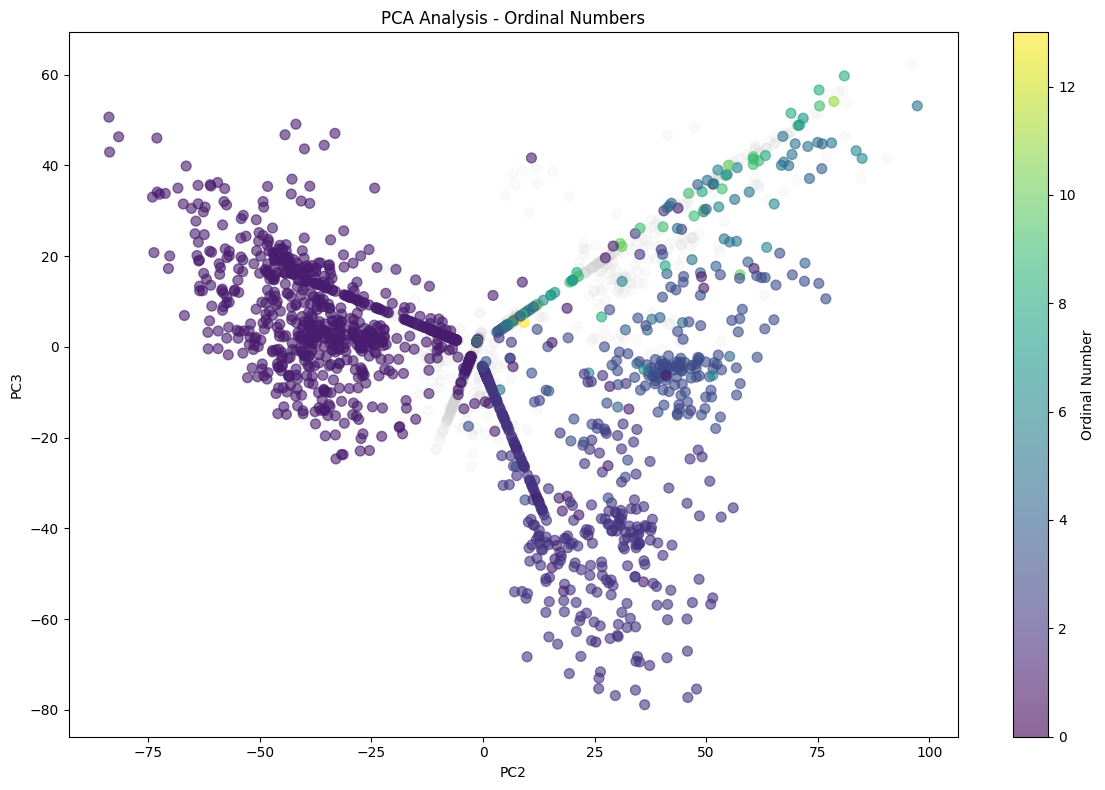

In [47]:
plot_pca_numbers_before_of(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [48]:
def plot_pca_numbers_before_of_plotly(
    pca_df: pd.DataFrame,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    # Clean context and extract numbers (reusing existing logic)
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["ordinal_number"] = pca_df["cleaned_context"].apply(extract_ordinal_number)

    # Create figure
    fig = go.Figure()

    # Plot background points (no ordinal number)
    non_number_mask = pca_df["ordinal_number"].isna()
    fig.add_trace(
        go.Scatter(
            x=pca_df.loc[non_number_mask, "PC2"],
            y=pca_df.loc[non_number_mask, "PC3"],
            mode="markers",
            marker=dict(color="lightgrey", opacity=0.1),
            name="No ordinal number",
            hovertemplate="PC2: %{x}<br>PC3: %{y}<br>Context: %{text}<extra></extra>",
            text=pca_df.loc[non_number_mask, "cleaned_context"],
        )
    )

    # Plot points with ordinal numbers using discrete colors
    number_mask = ~pca_df["ordinal_number"].isna()
    if number_mask.any():
        # Create discrete color map
        unique_ordinals = sorted(pca_df.loc[number_mask, "ordinal_number"].unique())  # type: ignore
        colors = px.colors.qualitative.Set1[: len(unique_ordinals)]  # type: ignore

        for ordinal, color in zip(unique_ordinals, colors):
            ordinal_mask = pca_df["ordinal_number"] == ordinal
            fig.add_trace(
                go.Scatter(
                    x=pca_df.loc[ordinal_mask, "PC2"],
                    y=pca_df.loc[ordinal_mask, "PC3"],
                    mode="markers",
                    marker=dict(color=color, opacity=0.8),
                    name=f"Ordinal {int(ordinal)}",
                    hovertemplate=(
                        "PC2: %{x}<br>PC3: %{y}<br>"
                        "Ordinal: "
                        f"{int(ordinal)}<br>"
                        "Context: %{text}<extra></extra>"
                    ),
                    text=pca_df.loc[ordinal_mask, "cleaned_context"],
                )
            )

    # Update layout
    fig.update_layout(
        title="PCA Analysis - Ordinal Numbers",
        xaxis_title="PC2",
        yaxis_title="PC3",
        showlegend=True,
        width=1000,
        height=800,
    )

    if save_figs:
        fig.write_html(
            f"{pca_path}/pca_plot_ordinal_numbers_interactive_{fs_splitting_cluster}.html"
        )
        fig.write_image(
            f"{pca_path}/pca_plot_ordinal_numbers_static_{fs_splitting_cluster}.png",
            width=1000,
            height=800,
        )

    fig.show()

In [49]:
plot_pca_numbers_before_of_plotly(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [50]:
plot_pca_numbers_before_of_plotly(
    pca_df_custom, pca_path, fs_splitting_cluster, save_figs
)

In [51]:
# plot_pca_numbers_before_of(pca_df_custom, pca_path, fs_splitting_cluster, save_figs)

In [52]:
def plot_pca_numbers_first_second_third(
    pca_df: pd.DataFrame,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    def extract_ordinal_number_first_second_third(context: str) -> int | None:
        context = context.lower().replace("|", " ")

        # Simplified ordinal map for just first, second, third
        ordinal_map = {
            "first": 1,
            "second": 2,
            "third": 3,
            "1st": 1,
            "2nd": 2,
            "3rd": 3,
        }

        for word, value in ordinal_map.items():
            if word in context:
                return value
        return None

    # Clean context and extract numbers
    pca_df["cleaned_context"] = pca_df["context"].str.replace("<|endoftext|>", "")
    pca_df["ordinal_number_first_second_third"] = pca_df["cleaned_context"].apply(
        extract_ordinal_number_first_second_third
    )

    # Set up colors for each ordinal
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # blue, orange, green
    labels = ["First", "Second", "Third"]

    plt.figure(figsize=(12, 8))

    # Plot background points
    non_number_mask = pca_df["ordinal_number"].isna()
    plt.scatter(
        pca_df.loc[non_number_mask, "PC2"],
        pca_df.loc[non_number_mask, "PC3"],
        color="lightgrey",
        alpha=0.1,
        s=50,
        label="Other tokens",
    )

    # Plot each ordinal number with its own color
    for i, (color, label) in enumerate(zip(colors, labels), start=1):
        mask = pca_df["ordinal_number_first_second_third"] == i
        plt.scatter(
            pca_df.loc[mask, "PC2"],
            pca_df.loc[mask, "PC3"],
            color=color,
            alpha=0.6,
            s=50,
            label=label,
        )

    plt.title("PCA Analysis - First, Second, Third")
    plt.xlabel("PC2")
    plt.ylabel("PC3")
    plt.legend()
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/pca_plot_first_second_third_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

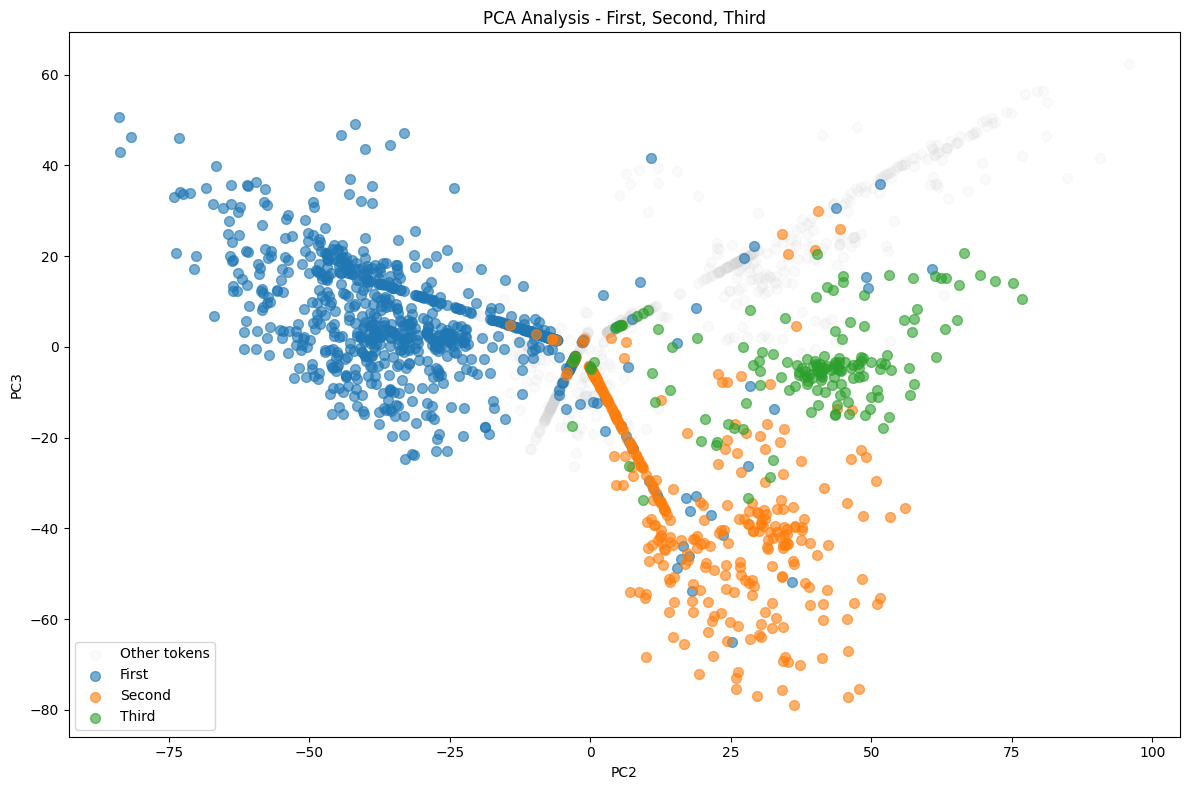

In [53]:
plot_pca_numbers_first_second_third(pca_df, pca_path, fs_splitting_cluster, save_figs)

In [54]:
feature_activations = pd.DataFrame(
    results["all_graph_feature_acts"],
    columns=[f"Feature {i}" for i in fs_splitting_nodes],
)

In [55]:
feature_activations_custom = pd.DataFrame(
    results_custom.all_graph_feature_acts.cpu().numpy(),
    columns=[f"Feature {i}" for i in fs_splitting_nodes],
)

In [56]:
def plot_ordinal_vs_activation_boxplot_per_feature(
    pca_df: pd.DataFrame,
    feature_activations: pd.DataFrame,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    # Filter for rows with ordinal numbers
    df_with_ordinals = pca_df[pca_df["ordinal_number"].notna()].copy()

    # Create a subplot for each feature
    n_features = feature_activations.shape[1]
    # Changed subplot arrangement to n_features rows and 1 column
    fig, axes = plt.subplots(n_features, 1, figsize=(8, 5 * n_features))

    for idx, (feature_name, ax) in enumerate(zip(feature_activations.columns, axes)):
        # Get feature activations for this specific feature
        feature_data = [
            feature_activations.loc[
                df_with_ordinals[df_with_ordinals["ordinal_number"] == i].index,
                feature_name,
            ]
            for i in sorted(df_with_ordinals["ordinal_number"].unique())
        ]

        # Create boxplot
        ax.boxplot(
            feature_data,
            labels=[
                f"#{int(i)}"
                for i in sorted(df_with_ordinals["ordinal_number"].unique())
            ],
        )

        ax.set_title(f"{feature_name}")
        ax.set_xlabel("Ordinal Number")
        ax.set_ylabel("Activation Strength")
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/activation_by_ordinal_boxplot_per_feature_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

In [57]:
# plot_ordinal_vs_activation_boxplot_per_feature(
#     pca_df_custom,
#     feature_activations_custom,
#     pca_path,
#     fs_splitting_cluster,
#     save_figs,
# )

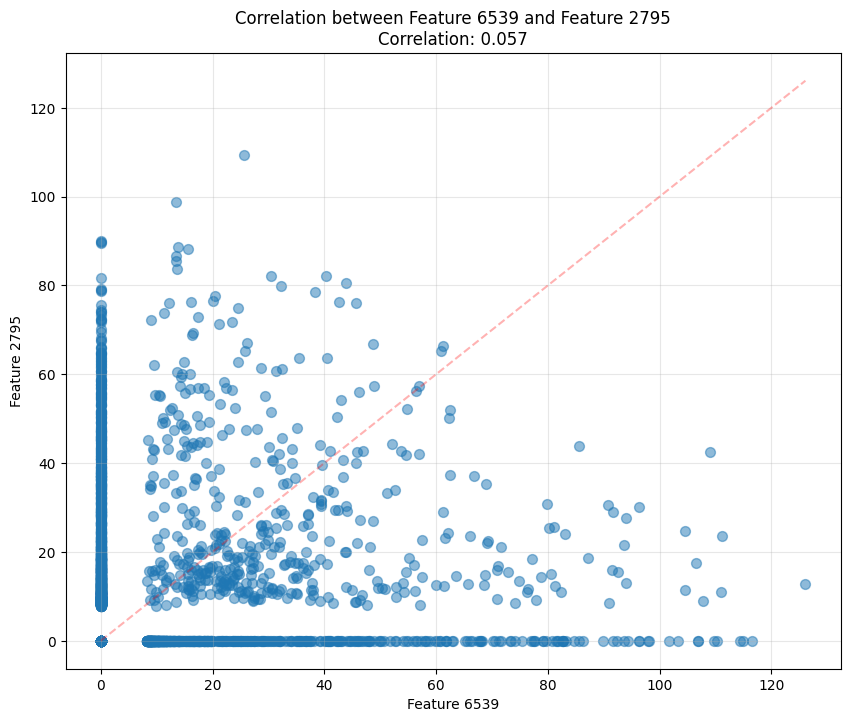

In [58]:
def plot_feature_correlation(
    feature_activations: pd.DataFrame,
    feature1: str,
    feature2: str,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    plt.figure(figsize=(10, 8))

    # Create scatter plot
    plt.scatter(
        feature_activations[feature1],
        feature_activations[feature2],
        alpha=0.5,
        s=50,
    )

    # Add correlation coefficient
    corr = feature_activations[feature1].corr(feature_activations[feature2])
    plt.title(f"Correlation between {feature1} and {feature2}\nCorrelation: {corr:.3f}")

    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.grid(True, alpha=0.3)

    # Add diagonal line for reference
    max_val = max(
        feature_activations[feature1].max(),
        feature_activations[feature2].max(),
    )
    plt.plot([0, max_val], [0, max_val], "r--", alpha=0.3)

    if save_figs:
        plt.savefig(
            f"{pca_path}/feature_correlation_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function to plot correlation between features 6539 and 2795
plot_feature_correlation(
    feature_activations,
    "Feature 6539",
    "Feature 2795",
    pca_path,
    fs_splitting_cluster,
    save_figs,
)

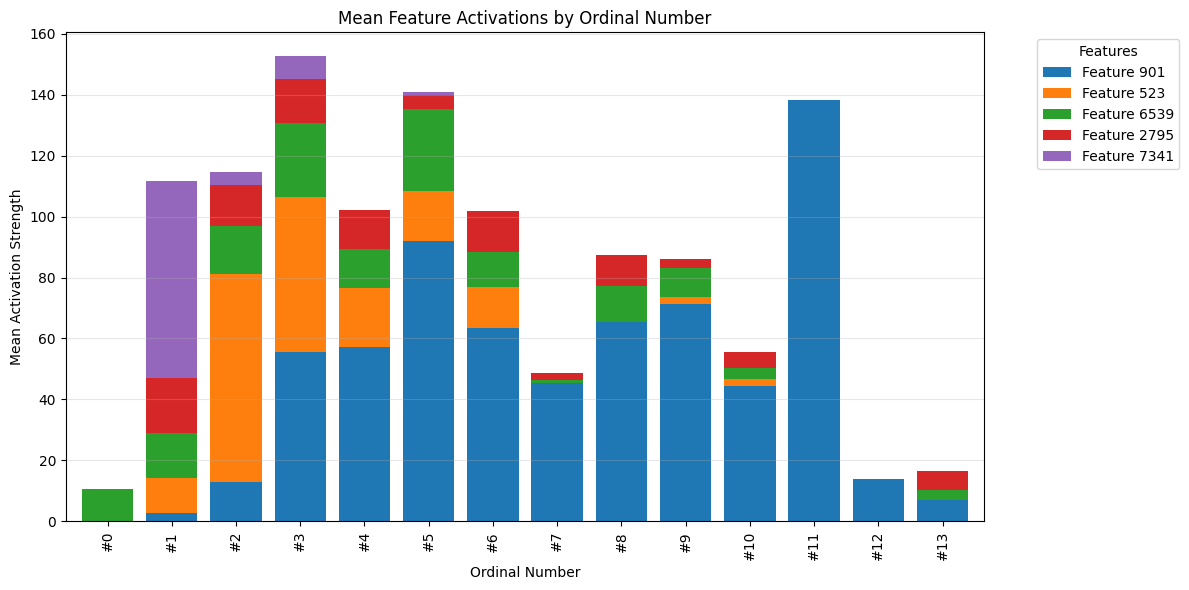

In [59]:
def plot_ordinal_mean_activations_stacked(
    pca_df: pd.DataFrame,
    feature_activations_array: np.ndarray,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    # Convert numpy array to DataFrame
    feature_activations = pd.DataFrame(
        feature_activations_array,
        columns=[f"Feature {i}" for i in fs_splitting_nodes],
    )

    # Filter for rows with ordinal numbers
    df_with_ordinals = pca_df[pca_df["ordinal_number"].notna()].copy()

    # Calculate mean activation for each feature per ordinal number
    mean_activations = []
    for ordinal in sorted(df_with_ordinals["ordinal_number"].unique()):
        indices = df_with_ordinals[df_with_ordinals["ordinal_number"] == ordinal].index
        means = feature_activations.loc[indices].mean()
        mean_activations.append(means)

    # Convert to DataFrame for easier plotting
    mean_df = pd.DataFrame(
        mean_activations,
        index=[
            f"#{int(i)}" for i in sorted(df_with_ordinals["ordinal_number"].unique())
        ],
    )

    # Create stacked bar chart
    _ = mean_df.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 6),
        width=0.8,
    )

    plt.title("Mean Feature Activations by Ordinal Number")
    plt.xlabel("Ordinal Number")
    plt.ylabel("Mean Activation Strength")
    plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    if save_figs:
        plt.savefig(
            f"{pca_path}/mean_activations_stacked_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()


# Call the function with your data
plot_ordinal_mean_activations_stacked(
    pca_df,
    results["all_graph_feature_acts"],
    pca_path,
    fs_splitting_cluster,
    save_figs,
)

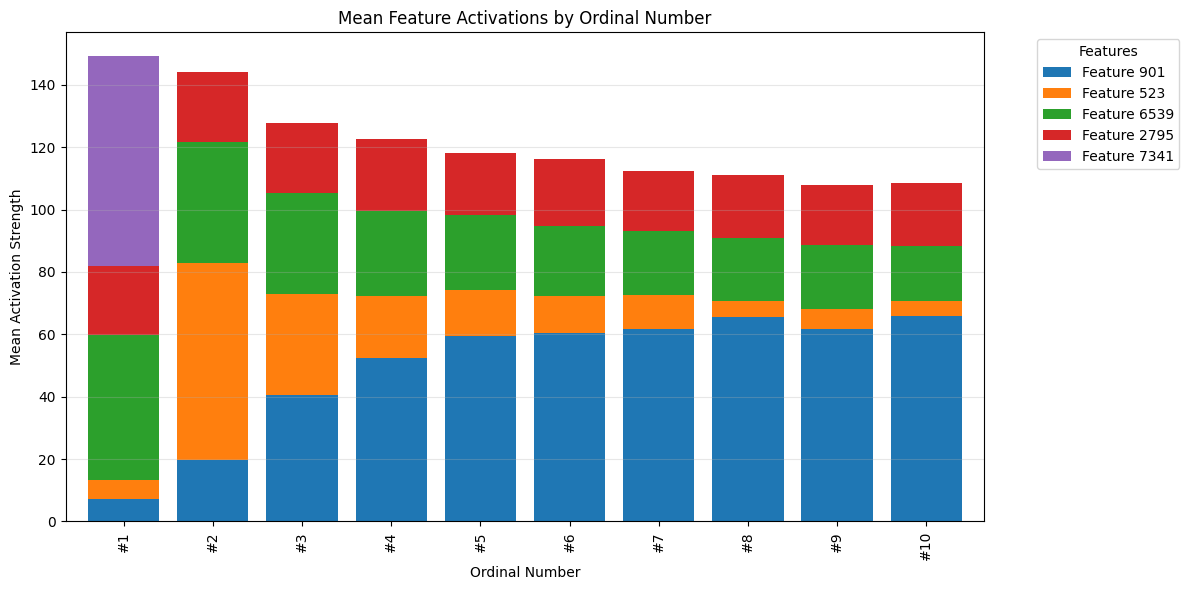

In [60]:
plot_ordinal_mean_activations_stacked(
    pca_df_custom,
    results_custom.all_graph_feature_acts.cpu().numpy(),
    pca_path,
    fs_splitting_cluster,
    save_figs,
)

In [61]:
def plot_ordinal_mean_activations_stacked_normalized(
    pca_df: pd.DataFrame,
    feature_activations_array: np.ndarray,
    pca_path: str,
    fs_splitting_cluster: int,
    save_figs: bool = False,
) -> None:
    # Convert numpy array to DataFrame
    feature_activations = pd.DataFrame(
        feature_activations_array,
        columns=[f"Feature {i}" for i in fs_splitting_nodes],
    )

    # Filter for rows with ordinal numbers
    df_with_ordinals = pca_df[pca_df["ordinal_number"].notna()].copy()

    # Calculate mean activation for each feature per ordinal number
    mean_activations = []
    for ordinal in sorted(df_with_ordinals["ordinal_number"].unique()):
        indices = df_with_ordinals[df_with_ordinals["ordinal_number"] == ordinal].index
        means = feature_activations.loc[indices].mean()
        mean_activations.append(means)

    # Convert to DataFrame for easier plotting
    mean_df = pd.DataFrame(
        mean_activations,
        index=[
            f"#{int(i)}" for i in sorted(df_with_ordinals["ordinal_number"].unique())
        ],
    )

    # Normalize each row so they sum to 1
    normalized_df = mean_df.div(mean_df.sum(axis=1), axis=0)

    # Create stacked bar chart with normalized values
    _ = normalized_df.plot(
        kind="bar",
        stacked=True,
        figsize=(12, 6),
        width=0.8,
    )

    plt.title("Relative Feature Activations by Ordinal Number")
    plt.xlabel("Ordinal Number")
    plt.ylabel("Relative Activation Proportion")
    plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3, axis="y")
    plt.tight_layout()

    # # Add text showing total activation before normalization
    # for i, total in enumerate(mean_df.sum(axis=1)):
    #     plt.text(
    #         i,
    #         1.02,
    #         f"Total: {total:.2f}",
    #         ha="center",
    #         va="bottom",
    #         rotation=0,
    #     )

    if save_figs:
        plt.savefig(
            f"{pca_path}/mean_activations_stacked_normalized_{fs_splitting_cluster}.png",
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()
    plt.close()

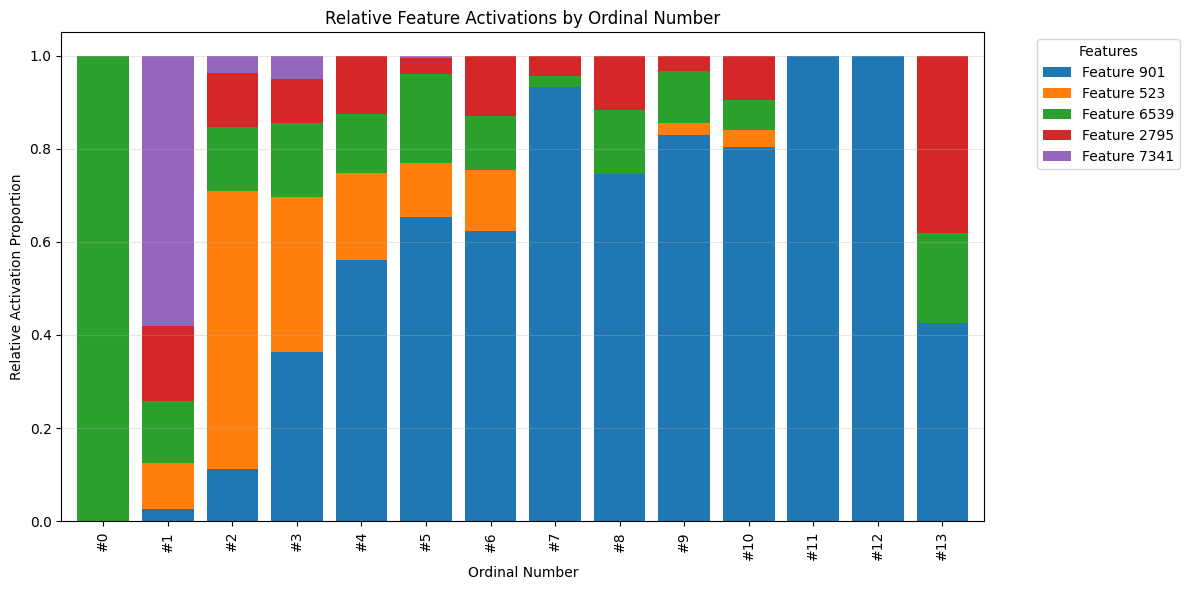

In [62]:
plot_ordinal_mean_activations_stacked_normalized(
    pca_df,
    results["all_graph_feature_acts"],
    pca_path,
    fs_splitting_cluster,
    save_figs,
)

In [65]:
subgraph_id = fs_splitting_cluster
sparse_thresholded_matrix = sparse.load_npz(
    os.path.join(
        results_path, "thresholded_matrices", "sparse_thresholded_matrix_1_5.npz"
    ),
)
subgraph, subgraph_df = generate_subgraph_plot_data_sparse(
    sparse_thresholded_matrix=sparse_thresholded_matrix,
    node_df=node_df,
    subgraph_id=subgraph_id,
)
plot_subgraph_static_from_nx(
    subgraph=subgraph,
    output_path=pj(pca_path, "subgraph_static"),
    subgraph_df=subgraph_df,
    node_info_df=node_df,
    save_figs=True,
    show_plot=True,
)

/Users/matthew/Documents/Github/sae_cooccurrence/sae_cooccurrence/pca.py:3209: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.

